In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
from matplotlib import pyplot as plt
import math

In [21]:
def complex_gauss(mean, std, dim, size): 
    vals = np.zeros((size, dim), dtype=np.complex_)
    for n in range(size): 
        for m in range(dim): 
            real = np.random.normal(mean, std)
            comp = np.random.normal(mean, std)
            vals[n,m] = real + comp*1j

    return vals

def complexMSELoss(z1, z2): 
    return torch.mean(torch.abs(z1-z2)**2)

In [4]:
dim, hidden_size = 1, [4]

class ExpActivation(nn.Module): 
    def __init__(self): 
        super().__init__()

    def forward(self, x): 
        return torch.exp(x)

class MLP(nn.Module): 
    def __init__(self, num_input, num_hidden, num_output): 
        super(MLP, self).__init__()
        layers = []
        for i in range(len(num_hidden)):
            if i == 0:
                layers.append(nn.Linear(num_input, num_hidden[i]))
            else: 
                layers.append(nn.Linear(num_hidden[i-1], num_hidden[i]))
            layers.append(ExpActivation())
        self.hidden = nn.Sequential(*layers)
        self.output = nn.Linear(num_hidden[-1], num_output)

    def forward(self, x): 
        x = self.hidden(x)
        x = self.output(x)

        return x

class NeuralNet(nn.Module): 
    def __init__(self): 
        super(NeuralNet, self).__init__()
        layer1 = MLP(dim, hidden_size, dim)
        self.fnn = layer1

    def forward(self, x): 
        x = self.fnn(x)

        return x

#### Model 1 trained from a uniform distribution with < 1 norm

In [25]:
model1 = NeuralNet()
model1.type(torch.complex64)
PATH1 = "state_dict_uni.pt"
model1.load_state_dict(torch.load(PATH1))
model1.eval()

NeuralNet(
  (fnn): MLP(
    (hidden): Sequential(
      (0): Linear(in_features=1, out_features=4, bias=True)
      (1): ExpActivation()
    )
    (output): Linear(in_features=4, out_features=1, bias=True)
  )
)

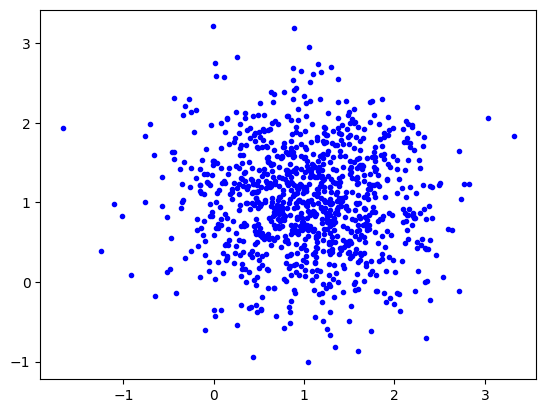

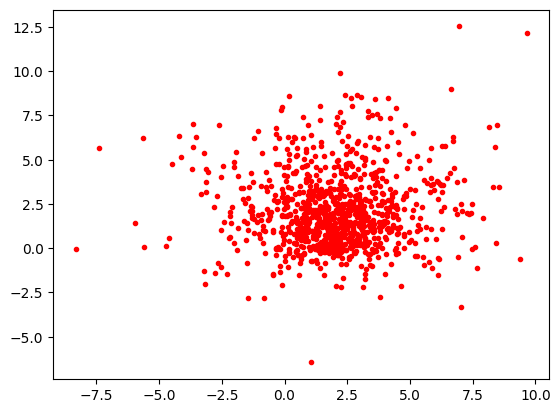

In [26]:
polynomial = np.polynomial.Polynomial([2, 0, 1])
mu, stdev, dim, test_len = 1, np.sqrt(1/2), 1, 1000
xtest_stdgauss = complex_gauss(mu, stdev, dim, test_len)
ytest_stdgauss = polynomial(xtest_stdgauss)
plt.plot(xtest_stdgauss.real, xtest_stdgauss.imag, 'b.')
plt.show()
plt.plot(ytest_stdgauss.real, ytest_stdgauss.imag, 'r.')
plt.show()

xtest_stdgauss = torch.tensor(xtest_stdgauss, dtype=torch.complex64).reshape(test_len, 1, dim)
ytest_stdgauss = torch.tensor(ytest_stdgauss, dtype=torch.complex64).reshape(test_len, 1, dim)

tensor(2.2845)


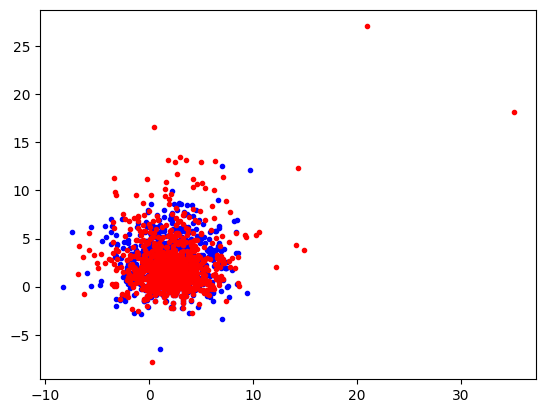

In [30]:
with torch.no_grad(): 
    true, preds = ytest_stdgauss, model1(xtest_stdgauss)
    print(complexMSELoss(true, preds))
    true, preds = torch.Tensor.numpy(ytest_stdgauss).reshape(test_len, dim), torch.Tensor.numpy(model1(xtest_stdgauss)).reshape(test_len, dim)

true_real, true_comp = true.real, true.imag
preds_real, preds_comp = preds.real, preds.imag

plt.plot(true_real, true_comp, 'b.')
plt.plot(preds_real, preds_comp, 'r.')
plt.show()

#### Model 2 trained from a uniform distribution of norm exactly 1

In [19]:
model2 = NeuralNet()
model2.type(torch.complex64)
PATH2 = "state_dict_uniform_circ.pt"
model2.load_state_dict(torch.load(PATH2))
model2.eval()

NeuralNet(
  (fnn): MLP(
    (hidden): Sequential(
      (0): Linear(in_features=1, out_features=4, bias=True)
      (1): ExpActivation()
    )
    (output): Linear(in_features=4, out_features=1, bias=True)
  )
)

tensor(0.2674)


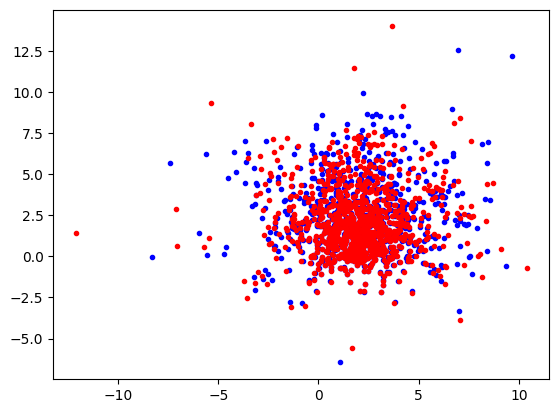

In [28]:
with torch.no_grad(): 
    true, preds = ytest_stdgauss, model2(xtest_stdgauss)
    print(complexMSELoss(true, preds))
    true, preds = torch.Tensor.numpy(ytest_stdgauss).reshape(test_len, dim), torch.Tensor.numpy(model2(xtest_stdgauss)).reshape(test_len, dim)

true_real, true_comp = true.real, true.imag
preds_real, preds_comp = preds.real, preds.imag

plt.plot(true_real, true_comp, 'b.')
plt.plot(preds_real, preds_comp, 'r.')
plt.show()